# EcoNex Optimization & Network Visualization

This notebook visualizes both the water distribution network topology (using WNTR) and the optimization results (flows, heads, pump schedules).

In [21]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import wntr
import networkx as nx
from pathlib import Path

# Add src to path
project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root))

# Set plot style
try:
    plt.style.use(['science', 'ieee', 'grid'])
except:
    plt.style.use('ggplot')

## 1. Load Optimization Results

Load the most recent optimization run results.

In [22]:
# Find most recent simulation run
results_dir = project_root / 'data' / 'results' / 'optimization'

if results_dir.exists() and results_dir.is_dir():
    run_dirs = sorted([d for d in results_dir.iterdir() if d.is_dir()], reverse=True)
    if run_dirs:
        run_dir = run_dirs[0]
        print(f"Loading results from: {run_dir.name}")
        
        # Check available files
        files = list(run_dir.glob('*.csv'))
        print("Found files:", [f.name for f in files])
    else:
        print("No optimization runs found.")
        run_dir = None
else:
    print(f"Results directory not found: {results_dir}")
    run_dir = None

Loading results from: run_20260126_191704
Found files: ['flows.csv', 'slack_pos.csv', 'slack_neg.csv', 'heads.csv', 'pump_status.csv']


## 2. Load EPANET Model

Load the network structure from the INP file.

In [23]:
if run_dir:
    # Try to find the input file in the run directory first (as copied by workflow)
    inp_files = list(run_dir.glob("*.inp"))
    if inp_files:
        inp_file_path = inp_files[0]
        print(f"Loading network from: {inp_file_path}")
        wn = wntr.network.WaterNetworkModel(str(inp_file_path))
    
        print(f"Nodes: {wn.num_nodes}")
        print(f"Links: {wn.num_links}")
        print(f"Pumps: {wn.num_pumps}")
        print(f"Valves: {wn.num_valves}")
        print(f"Tanks: {wn.num_tanks}")
    else:
        print("No INP file found in run directory. Check if saving is enabled.")
        wn = None

Loading network from: /Users/abdelrahmanaltawil/Developer/GitHub/publications-implementation/A stochastic model for the daily coordination of pumped storage hydro plants and wind power plants/data/results/optimization/run_20260126_191704/GNET.inp
Nodes: 50
Links: 71
Pumps: 2
Valves: 0
Tanks: 3


## 3. Visualize Network Topology

<Figure size 1200x800 with 0 Axes>

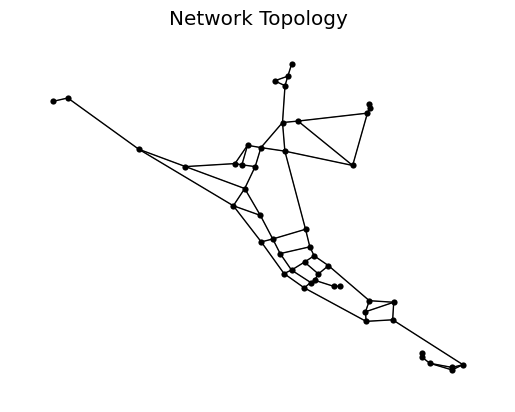

In [24]:
if wn:
    plt.figure(figsize=(12, 8))
    wntr.graphics.plot_network(wn, node_size=20, title='Network Topology')
    plt.show()

## 4. Visualize Elevations

<Figure size 1200x800 with 0 Axes>

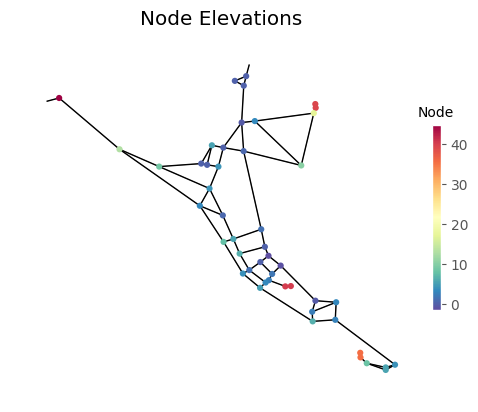

In [25]:
if wn:
    elevation = wn.query_node_attribute('elevation')
    plt.figure(figsize=(12, 8))
    wntr.graphics.plot_network(wn, node_attribute=elevation, node_size=20, title='Node Elevations')
    plt.show()

In [26]:
def load_and_pivot(filepath, value_col, index_col, columns_col):
    """Load CSV strings and pivot to wide format."""
    if filepath.exists():
        try:
            df = pd.read_csv(filepath)
            if not df.empty:
                return df.pivot(index=index_col, columns=columns_col, values=value_col)
        except Exception as e:
            print(f"Error loading {filepath.name}: {e}")
    return None

if run_dir:
    # Load and pivot CSVs for easy plotting (Index=Time, Columns=ID)
    df_flows = load_and_pivot(run_dir / 'flows.csv', 'flow_rate', 'time', 'link')
    if df_flows is not None:
        print(f"Loaded Flows: {df_flows.shape}")
        
    df_heads = load_and_pivot(run_dir / 'heads.csv', 'head', 'time', 'node')
    if df_heads is not None:
        print(f"Loaded Heads: {df_heads.shape}")
        
    df_status = load_and_pivot(run_dir / 'pump_status.csv', 'status', 'time', 'pump')
    if df_status is not None:
        print(f"Loaded Pump Status: {df_status.shape}")
        
    # Load Metadata
    try:
        with open(run_dir / 'summary.json') as f:
            summary = json.load(f)
        print(f"Objective Value: {summary.get('objective_value', 'N/A')}")
    except FileNotFoundError:
        print("summary.json not found")

Loaded Flows: (24, 71)
Loaded Heads: (24, 50)
Loaded Pump Status: (24, 2)
Objective Value: 53262716.00585595


## 5. Tank Levels / Heads

Plot hydraulic heads at network nodes over time.

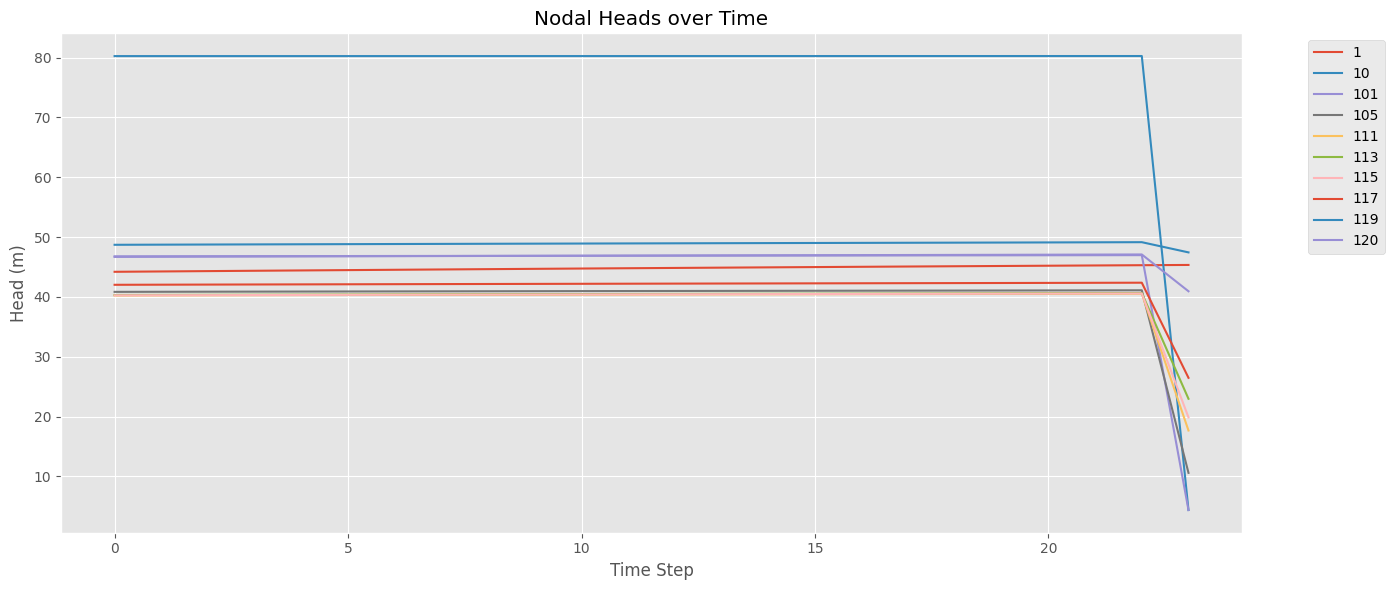

In [28]:
if df_heads is not None:
    plt.figure(figsize=(14, 6))
    # Plot a subset of nodes if too many
    cols_to_plot = df_heads.columns[:10]  
    df_heads[cols_to_plot].plot(ax=plt.gca())
    plt.title('Nodal Heads over Time')
    plt.ylabel('Head (m)')
    plt.xlabel('Time Step')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 6. Pump Operations

Visualize pump scheduling (ON/OFF status).

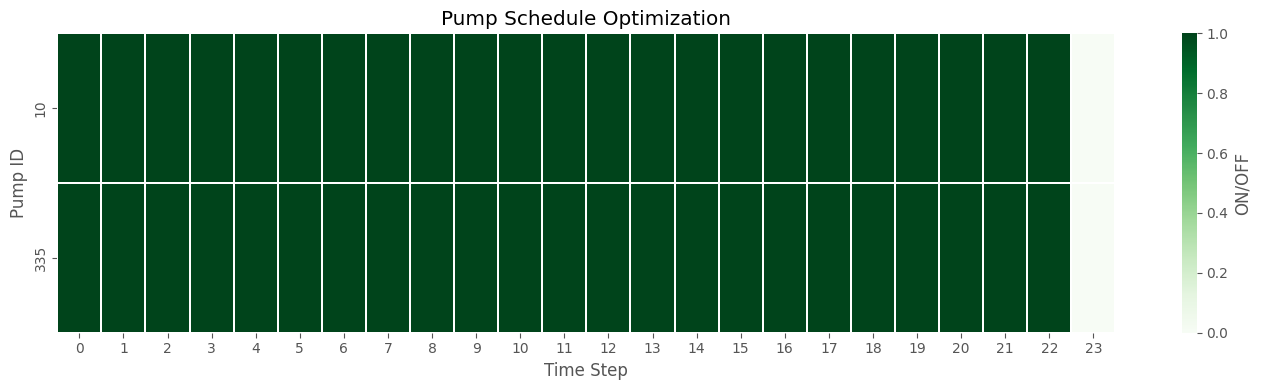

In [29]:
if df_status is not None:
    plt.figure(figsize=(14, 4))
    sns.heatmap(df_status.T, cmap='Greens', cbar_kws={'label': 'ON/OFF'}, linewidths=0.1)
    plt.title('Pump Schedule Optimization')
    plt.xlabel('Time Step')
    plt.ylabel('Pump ID')
    plt.tight_layout()
    plt.show()

## 7. Link Flows

Visualize flow rates in network links over time.

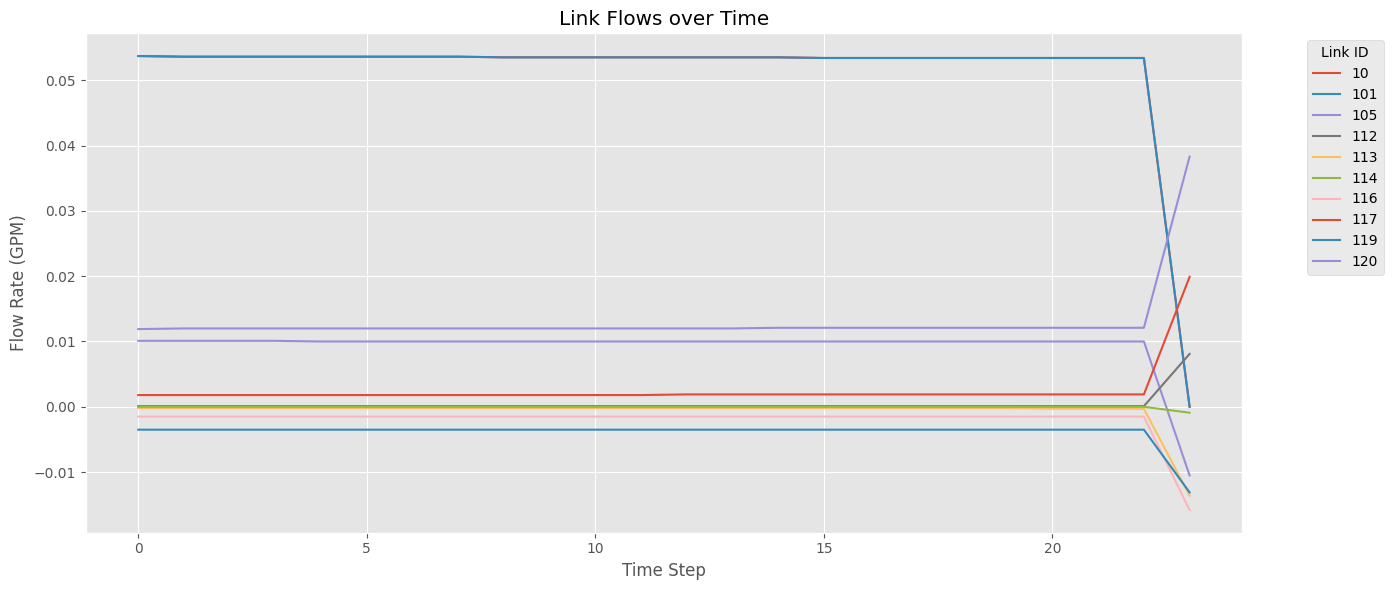

In [30]:
if df_flows is not None:
    plt.figure(figsize=(14, 6))
    # Plot a subset of links if too many
    cols_to_plot = df_flows.columns[:10]  
    df_flows[cols_to_plot].plot(ax=plt.gca())
    plt.title('Link Flows over Time')
    plt.ylabel('Flow Rate (GPM)')
    plt.xlabel('Time Step')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Link ID')
    plt.grid(True)
    plt.tight_layout()
    plt.show()